# Assigment 14 | Applied Machine Learning | Paras Ahuja

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import os 
import struct
import sys
import IPython.display as disp
import random
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf

print(f"TensorFlow Ver.: {tf.__version__}")
print(f"CUDA Avaiable: {tf.test.gpu_device_name()}")
tf.test.is_built_with_cuda()

TensorFlow Ver.: 2.4.0
CUDA Avaiable: 


False

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import cv2
print(f"CV2 Ver.: {cv2.__version__}")

CV2 Ver.: 4.4.0


### Download the dataset, unzip and explore the file folders. Load the image dataset with training and testing grouped.

In [3]:
path = os.getcwd()
directories = [d for d in os.listdir() if not d.__contains__('.')]

Now we have information on directories in our current working directory. We need to dig deeper because some of the folders have more folders.

In [4]:
# both seg_test, and set_train have same directories
for directory in directories:
    if not directory == "seg_pred":
        files = os.listdir(path+"/"+directory)
    break

In [5]:
%%time

IMGSIZE = (128, 128)
FNAMES = files

def load_images(path, labels):
    X_tr, y_tr, X_ts, y_ts = [], [], [], []
    for label in labels:    
        p = path + '/seg_train/' + label  
        for f in sorted([_ for _ in os.listdir(p) if _.lower().endswith('.jpg')]):    
            X_tr += [cv2.resize(cv2.imread(os.path.join(p,f)), IMGSIZE)]        
            y_tr += [FNAMES.index(label)]
        p = path + '/seg_test/' + label    
        for f in sorted([_ for _ in os.listdir(p) if _.lower().endswith('.jpg')]):        
            X_ts += [cv2.resize(cv2.imread(os.path.join(p,f)), IMGSIZE)]        
            y_ts += [FNAMES.index(label)]

    return X_tr, y_tr, X_ts, y_ts

X_tr, y_tr, X_ts, y_ts = load_images(path, files)

CPU times: user 6.39 s, sys: 1.26 s, total: 7.65 s
Wall time: 7.66 s


We now have images in an array format. Images have been loaded. Let's check the number of channels.

In [6]:
channels = len(X_tr[0][0][0])
disp.display_markdown(f"__Number of Channels:__ {channels}", raw=True)

__Number of Channels:__ 3

We have three channels.

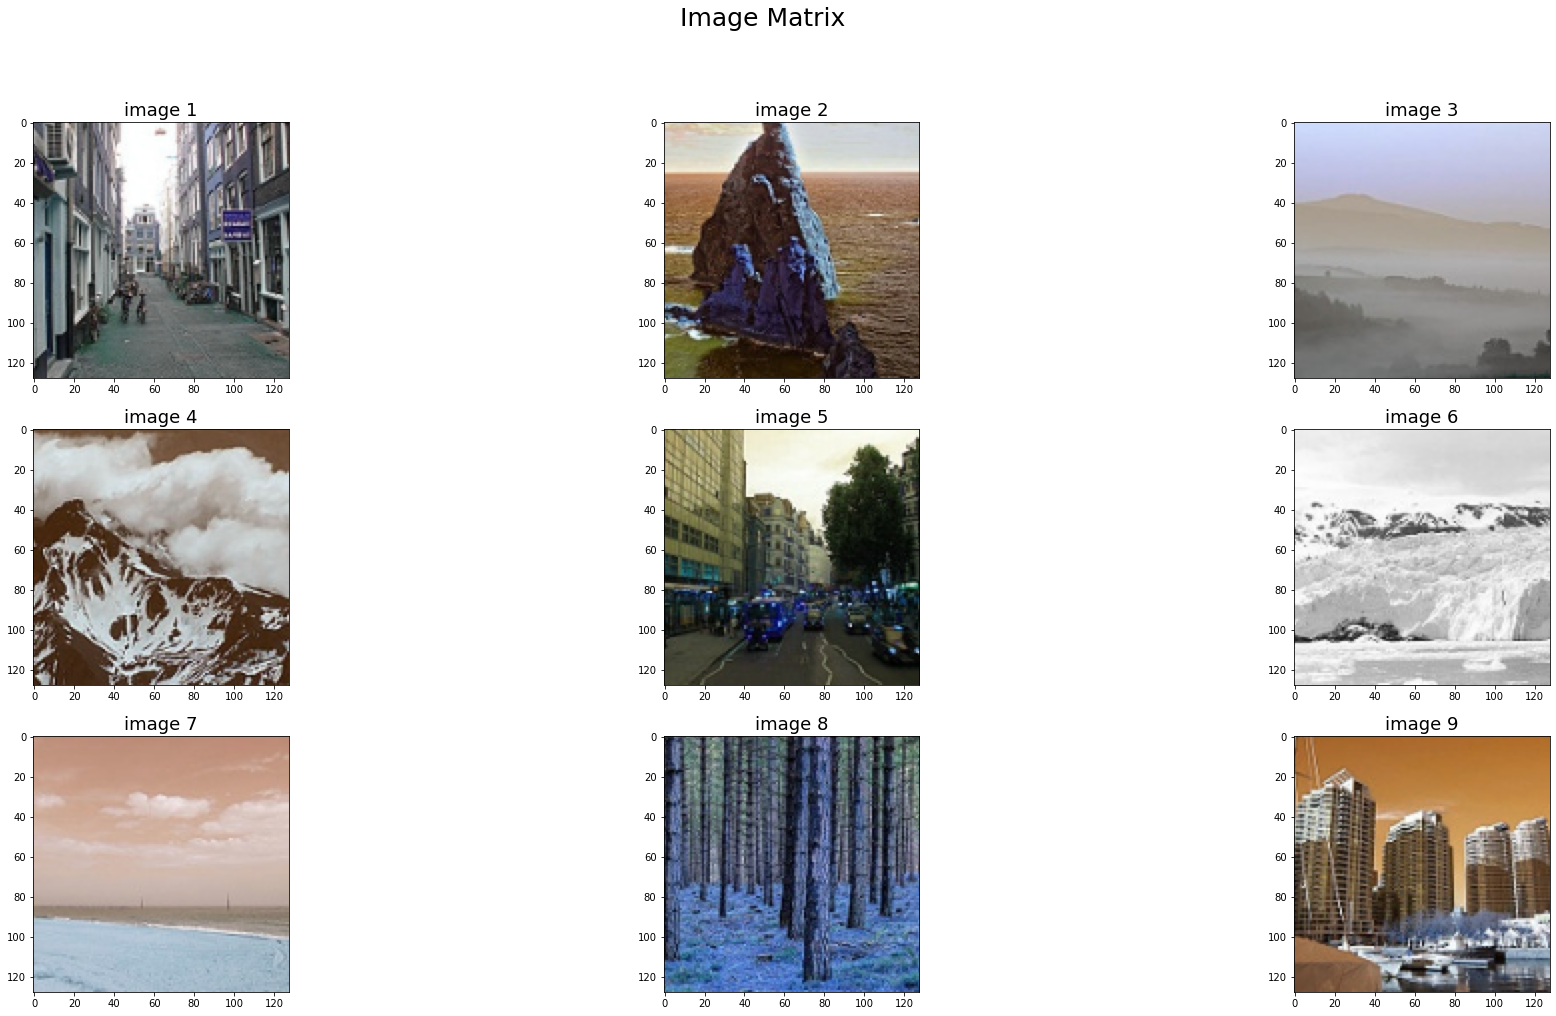

In [7]:
NUM_ROWS = 3
IMGs_IN_ROW = 3
sample = random.sample(X_tr, NUM_ROWS*IMGs_IN_ROW)
f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(32,16))
for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.imshow(sample[j*IMGs_IN_ROW+i])
        ax.set_title(f'image {j*IMGs_IN_ROW+i+1}', fontsize=18)

title = 'Image Matrix'
f.suptitle(title, fontsize=25)
plt.show()  

### Convert the imageset to numpy array, such as the array size is (14034, 128, 128, 3). Scale the imageset to [0-1].

In [8]:
K_CLASSES = len(FNAMES)
print(f"#Classes: {K_CLASSES}")

X_train = np.array(X_tr, dtype='float32')
X_test = np.array(X_ts, dtype='float32')
y_train = np.array(y_tr, dtype='float32')
y_test = np.array(y_ts, dtype='float32')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(X_train.min(), y_train.max(), X_test.min(), y_test.max())


X_tr = X_train/255.0
X_ts = X_test/255.0
y_tr = y_train
y_ts = y_test

#Classes: 6
(14034, 128, 128, 3) (14034,) (3000, 128, 128, 3) (3000,)
0.0 5.0 0.0 5.0


### Create a convolutional neural network to train and report its performance on the testing portion of the dataset. 95% reclassification and 75% testing accuracy should beeasily achievable without any hyperparameter tuning. (Hint: My model, which is similar to the model in module notebook, took around 10 minutes to train 10 epochs.)

In [10]:
KSIZE = (3, 3)
NUM_EPOCHS = 100
BATCH_SIZE = 32
ES_PATIENCE = 15

In [11]:
X_tr_2, X_val, y_tr_2, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=0)

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

cnn1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=KSIZE, padding="same", activation="sigmoid"), 
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    tf.keras.layers.Dense(units=K_CLASSES, activation="softmax")
])

cnn1.build(input_shape=(None, IMGSIZE[0], IMGSIZE[1], 3))

cnn1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

cnn1.save_weights("as14_cnn1_weights.h5")

In [15]:
%%time
his1 = cnn1.fit(X_tr_2, y_tr_2, epochs=NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0, 
               callbacks=[EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)], 
               validation_data=(X_val, y_val))

CPU times: user 9h 27min 53s, sys: 36min 25s, total: 10h 4min 18s
Wall time: 1h 1min 1s


In [16]:
y_pred = cnn1.predict_classes(X_ts)
print(f"Accuracy = {sum(y_pred==y_ts)/len(y_ts):.3f}", '\n')

print(confusion_matrix(y_ts, y_pred))

/Users/paras/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy = 0.856 

[[465   0   2   2   4   1]
 [  1 285   5 125   7  14]
 [  2   0 455   6  80  10]
 [  4   5   3 480   6   3]
 [  3   0  60   0 451  11]
 [  2   2  31  10  34 431]]


### Add regularization and/or drop-out features to your CNN. Report your model's best performance

In [21]:
%%time
tf.keras.backend.clear_session()
tf.random.set_seed(0)

cnn2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=16, activation="sigmoid"), 
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Dense(units=32, activation="sigmoid"), 
    tf.keras.layers.Dropout(rate=0.2),
    
    
    tf.keras.layers.Dense(units=K_CLASSES, activation="softmax")
])

cnn2.build(input_shape=(None, IMGSIZE[0], IMGSIZE[1], 3))

cnn2.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

his2 = cnn2.fit(X_tr_2, y_tr_2, epochs=NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0, 
               callbacks=[EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)], 
               validation_data=(X_val, y_val))

y_pred = cnn2.predict_classes(X_ts)
print(f"Accuracy = {sum(y_pred==y_ts)/len(y_ts):.3f}", '\n')

print(confusion_matrix(y_ts, y_pred))

Epoch 00052: early stopping
Accuracy = 0.838 

[[457   3   5   4   4   1]
 [  4 359   2  44   9  19]
 [  2   5 410   7  85  44]
 [  8  43   4 436   2   8]
 [  1   5  59   1 422  37]
 [  0  15  25   2  39 429]]
CPU times: user 5h 21min 48s, sys: 22min 33s, total: 5h 44min 22s
Wall time: 35min 4s


In [22]:
%%time
tf.keras.backend.clear_session()
tf.random.set_seed(0)

cnn3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=KSIZE, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=KSIZE, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=KSIZE, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=KSIZE, padding="same", activation="relu"), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=16, activation="sigmoid"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.2),
    
    tf.keras.layers.Dense(units=32, activation="sigmoid"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.2),
    
    
    tf.keras.layers.Dense(units=K_CLASSES, activation="softmax")
])

cnn3.build(input_shape=(None, IMGSIZE[0], IMGSIZE[1], 3))

cnn3.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

his3 = cnn3.fit(X_tr_2, y_tr_2, epochs=NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0, 
               callbacks=[EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)], 
               validation_data=(X_val, y_val))

y_pred = cnn3.predict_classes(X_ts)
print(f"Accuracy = {sum(y_pred==y_ts)/len(y_ts):.3f}", '\n')

print(confusion_matrix(y_ts, y_pred))

Epoch 00060: early stopping
Accuracy = 0.754 

[[441   4   3  16   5   5]
 [  5 324  11  79   9   9]
 [  3   4 322   7 212   5]
 [  7  25   4 458   5   2]
 [  2   1  40   2 472   8]
 [  2   6  50  11 195 246]]
CPU times: user 9h 18min 9s, sys: 33min 42s, total: 9h 51min 52s
Wall time: 1h 47s


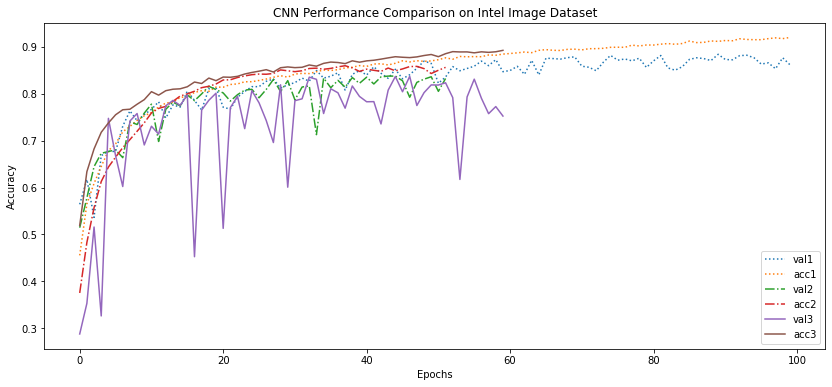

In [27]:
plt.figure(figsize=(14, 6))
plt.plot(his1.history['val_accuracy'], label="val1", ls=":")
plt.plot(his1.history['accuracy'], label="acc1", ls=":")
plt.plot(his2.history['val_accuracy'], label="val2", ls="-.")
plt.plot(his2.history['accuracy'], label="acc2", ls="-.")
plt.plot(his3.history['val_accuracy'], label="val3")
plt.plot(his3.history['accuracy'], label="acc3")
plt.title("CNN Performance Comparison on Intel Image Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We notice here that val3 and acc3 are the worse performers. Others perform quite well. 